# OCR CNN - Professional Implementation

This notebook implements a Convolutional Neural Network (CNN) for Optical Character Recognition (OCR) to classify alphanumeric characters (0-9, A-Z).

## Table of Contents
1. [Setup and Imports](#setup)
2. [Configuration](#config)
3. [Data Loading and Preprocessing](#data)
4. [Model Architecture](#model)
5. [Training](#training)
6. [Evaluation and Visualization](#evaluation)
7. [Inference](#inference)

## 1. Setup and Imports <a id='setup'></a>

Import all necessary libraries for data processing, model building, and visualization.

In [1]:
# Standard library imports
import os
from pathlib import Path

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


## 2. Configuration <a id='config'></a>

Define all hyperparameters and configuration settings in one place for easy modification.

In [2]:
# Configuration dictionary for easy parameter management
CONFIG = {
    # Data paths
    'data_dir': r'D:\Academic\My Courses\Year 3\Deep Learning\Project\data',  # Change this to your data directory
    'train_dir': 'training_data',
    'test_dir': 'testing_data',
    
    # Model hyperparameters
    'img_size': 64,
    'batch_size': 32,
    'num_epochs': 10,
    'learning_rate': 0.001,
    
    # Data augmentation (optional - set to True to enable)
    'use_augmentation': False,
    
    # Training settings
    'num_workers': 2,  # For DataLoader
    'pin_memory': True,  # For faster data transfer to GPU
    
    # Device configuration
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Create full paths
CONFIG['train_path'] = os.path.join(CONFIG['data_dir'], CONFIG['train_dir'])
CONFIG['test_path'] = os.path.join(CONFIG['data_dir'], CONFIG['test_dir'])

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  data_dir: D:\Academic\My Courses\Year 3\Deep Learning\Project\data
  train_dir: training_data
  test_dir: testing_data
  img_size: 64
  batch_size: 32
  num_epochs: 10
  learning_rate: 0.001
  use_augmentation: False
  num_workers: 2
  pin_memory: True
  device: cuda
  train_path: D:\Academic\My Courses\Year 3\Deep Learning\Project\data\training_data
  test_path: D:\Academic\My Courses\Year 3\Deep Learning\Project\data\testing_data


## 3. Data Loading and Preprocessing <a id='data'></a>

### 3.1 Data Transformations

Define image transformations for training and testing. Optionally includes data augmentation for better generalization.

In [3]:
# Base transformations (always applied)
base_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Training transformations with optional augmentation
if CONFIG['use_augmentation']:
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.Grayscale(num_output_channels=1),
        # Data augmentation techniques
        transforms.RandomRotation(10),  # Rotate by ±10 degrees
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    print("Using data augmentation for training")
else:
    train_transform = base_transform
    print("Using base transformations only")

# Test transformations (no augmentation)
test_transform = base_transform

Using base transformations only


### 3.2 Dataset Loading

Load training and testing datasets using PyTorch's ImageFolder.

In [4]:
# Load datasets
try:
    train_dataset = datasets.ImageFolder(
        CONFIG['train_path'],
        transform=train_transform
    )
    
    test_dataset = datasets.ImageFolder(
        CONFIG['test_path'],
        transform=test_transform
    )
    
    print(f"✓ Successfully loaded datasets")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Testing samples: {len(test_dataset)}")
    print(f"  Number of classes: {len(train_dataset.classes)}")
    print(f"  Classes: {train_dataset.classes}")
    
except Exception as e:
    print(f"✗ Error loading datasets: {e}")
    print("Please check your data directory paths")

✓ Successfully loaded datasets
  Training samples: 20529
  Testing samples: 1008
  Number of classes: 36
  Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### 3.3 Data Loaders

Create data loaders for efficient batch processing during training and testing.

In [5]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory']
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory']
)

print(f"Data loaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Testing batches: {len(test_loader)}")

Data loaders created:
  Training batches: 642
  Testing batches: 32


### 3.4 Visualize Sample Data

Display a few sample images to verify data loading.

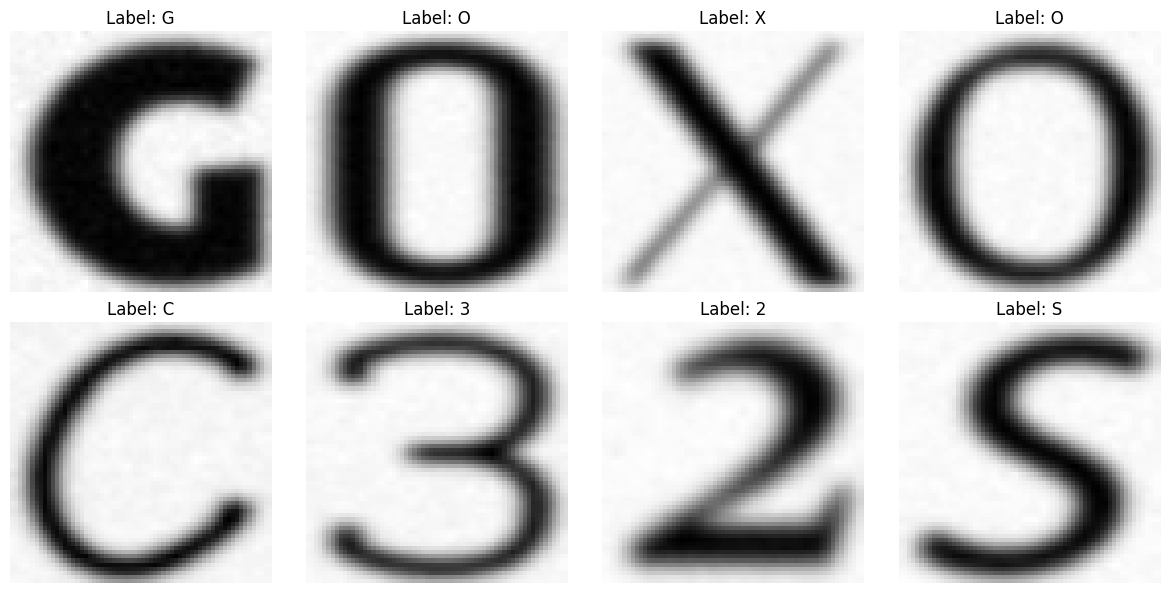

In [6]:
# Visualize a batch of training images
def visualize_batch(data_loader, num_images=8):
    """
    Visualize a batch of images from the data loader.
    
    Args:
        data_loader: PyTorch DataLoader
        num_images: Number of images to display
    """
    images, labels = next(iter(data_loader))
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for idx in range(min(num_images, len(images))):
        img = images[idx].squeeze().numpy()
        # Denormalize for display
        img = (img * 0.5) + 0.5
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"Label: {train_dataset.classes[labels[idx]]}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_batch(train_loader)

## 4. Model Architecture <a id='model'></a>

Define the CNN architecture for OCR classification.

In [7]:
class OCRCNN(nn.Module):
    """
    Convolutional Neural Network for OCR classification.
    
    Architecture:
    - Conv Layer 1: 1 -> 32 channels, 3x3 kernel
    - MaxPool: 2x2
    - Conv Layer 2: 32 -> 64 channels, 3x3 kernel
    - MaxPool: 2x2
    - Fully Connected 1: 64*16*16 -> 256
    - Fully Connected 2: 256 -> num_classes
    
    Args:
        num_classes (int): Number of output classes
    """
    
    def __init__(self, num_classes):
        super(OCRCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout for regularization (optional)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 64, 64)
        
        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes)
        """
        # Conv block 1: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))  # Output: (batch, 32, 32, 32)
        
        # Conv block 2: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Output: (batch, 64, 16, 16)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Output: (batch, 64*16*16)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # Output: (batch, 256)
        x = self.dropout(x)  # Apply dropout during training
        x = self.fc2(x)  # Output: (batch, num_classes)
        
        return x

# Initialize model
num_classes = len(train_dataset.classes)
model = OCRCNN(num_classes=num_classes)

# Move model to device (GPU if available)
device = torch.device(CONFIG['device'])
model = model.to(device)

print(f"Model initialized on device: {device}")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model initialized on device: cuda

Model architecture:
OCRCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=36, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 4,222,628
Trainable parameters: 4,222,628


## 5. Training <a id='training'></a>

### 5.1 Loss Function and Optimizer

Define the loss function and optimizer for training.

In [8]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

# Optional: Learning rate scheduler for better convergence
# Reduces learning rate when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate scheduler: ReduceLROnPlateau")

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate scheduler: ReduceLROnPlateau


c:\Users\FreeComp\anaconda3\envs\ai\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### 5.2 Training and Validation Functions

Define helper functions for training and validation.

In [9]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    
    Args:
        model: PyTorch model
        data_loader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.train()  # Set model to training mode
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(data_loader, desc="Training", leave=False)
    
    for images, labels in pbar:
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, data_loader, criterion, device):
    """
    Validate the model for one epoch.
    
    Args:
        model: PyTorch model
        data_loader: Validation data loader
        criterion: Loss function
        device: Device to validate on
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.eval()  # Set model to evaluation mode
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(data_loader, desc="Validating", leave=False)
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in pbar:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("Training and validation functions defined")

Training and validation functions defined


### 5.3 Training Loop

Train the model for the specified number of epochs.

In [10]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

# Training loop
print(f"Starting training for {CONFIG['num_epochs']} epochs...\n")

for epoch in range(CONFIG['num_epochs']):
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
    
    # Update learning rate scheduler
    scheduler.step(test_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
    print("-" * 60)

print("\nTraining completed!")

Starting training for 10 epochs...

Epoch 1/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:05<?, ?it/s]

Train Loss: 0.6162 | Train Acc: 82.36%
Test Loss:  0.0679 | Test Acc:  97.52%
------------------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:06<?, ?it/s]

Train Loss: 0.2345 | Train Acc: 92.73%
Test Loss:  0.0611 | Test Acc:  96.63%
------------------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:06<?, ?it/s]

Train Loss: 0.1734 | Train Acc: 94.21%
Test Loss:  0.0441 | Test Acc:  98.12%
------------------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:06<?, ?it/s]

Train Loss: 0.1420 | Train Acc: 95.19%
Test Loss:  0.0338 | Test Acc:  98.21%
------------------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:06<?, ?it/s]

Train Loss: 0.1152 | Train Acc: 95.88%
Test Loss:  0.0410 | Test Acc:  97.82%
------------------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:06<?, ?it/s]

Train Loss: 0.1090 | Train Acc: 96.15%
Test Loss:  0.0372 | Test Acc:  98.21%
------------------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:06<?, ?it/s]

Train Loss: 0.0977 | Train Acc: 96.39%
Test Loss:  0.0324 | Test Acc:  98.51%
------------------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:06<?, ?it/s]

Train Loss: 0.0888 | Train Acc: 96.53%
Test Loss:  0.0346 | Test Acc:  98.21%
------------------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:06<?, ?it/s]

Train Loss: 0.0816 | Train Acc: 96.90%
Test Loss:  0.0376 | Test Acc:  97.62%
------------------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/642 [00:06<?, ?it/s]

Validating:   0%|          | 0/32 [00:06<?, ?it/s]

Train Loss: 0.0698 | Train Acc: 97.35%
Test Loss:  0.0328 | Test Acc:  98.02%
------------------------------------------------------------

Training completed!


## 6. Evaluation and Visualization <a id='evaluation'></a>

### 6.1 Plot Training History

Visualize the training and validation loss and accuracy curves.

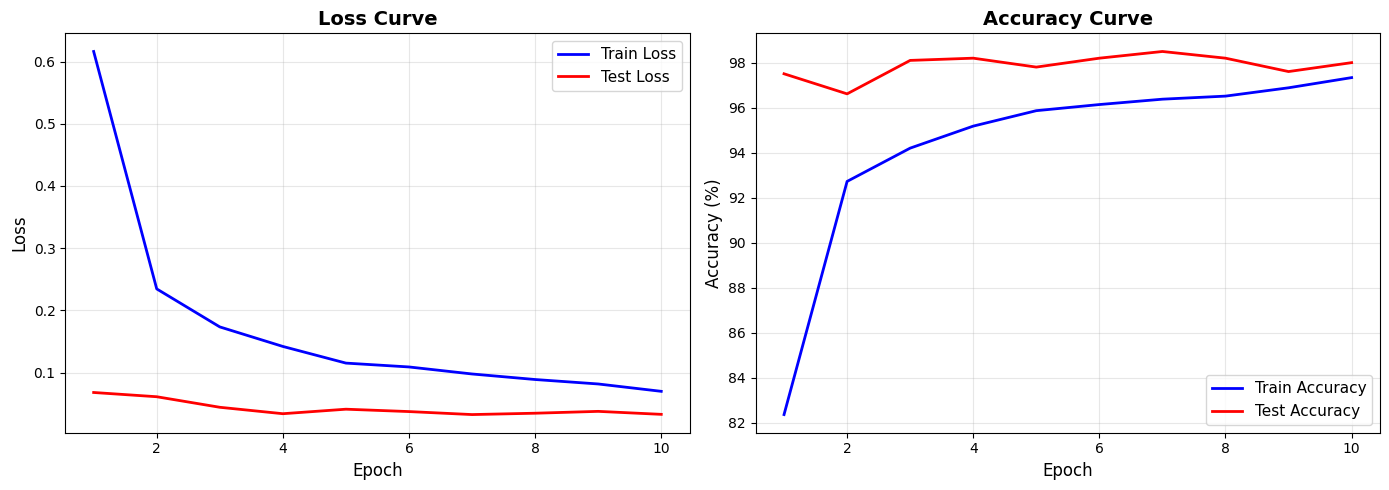

In [11]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy.
    
    Args:
        history (dict): Dictionary containing training history
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
    ax1.set_title('Loss Curve', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    ax2.plot(epochs, history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
    ax2.set_title('Accuracy Curve', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

### 6.2 Final Model Performance

Display final training and testing metrics.

In [12]:
print("="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Test Loss: {history['test_loss'][-1]:.4f}")
print(f"Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
print("="*60)

# Best epoch
best_epoch = np.argmax(history['test_acc']) + 1
best_acc = max(history['test_acc'])
print(f"\nBest Test Accuracy: {best_acc:.2f}% (Epoch {best_epoch})")

FINAL MODEL PERFORMANCE
Final Train Loss: 0.0698
Final Train Accuracy: 97.35%
Final Test Loss: 0.0328
Final Test Accuracy: 98.02%

Best Test Accuracy: 98.51% (Epoch 7)


## 7. Inference <a id='inference'></a>

### 7.1 Prediction Function

Define a function to predict the class of a single image.

In [13]:
def predict_image(image_path, model, transform, device, class_names):
    """
    Predict the class of a single image.
    
    Args:
        image_path (str): Path to the image file
        model: Trained PyTorch model
        transform: Image transformation pipeline
        device: Device to run inference on
        class_names (list): List of class names
    
    Returns:
        tuple: (predicted_class, confidence)
    """
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('L')
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Set model to evaluation mode
        model.eval()
        
        # Make prediction
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = F.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
        
        predicted_class = class_names[predicted.item()]
        confidence_score = confidence.item() * 100
        
        return predicted_class, confidence_score
        
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, None

print("Prediction function defined")

Prediction function defined


### 7.2 Test Prediction

Test the prediction function on a sample image.

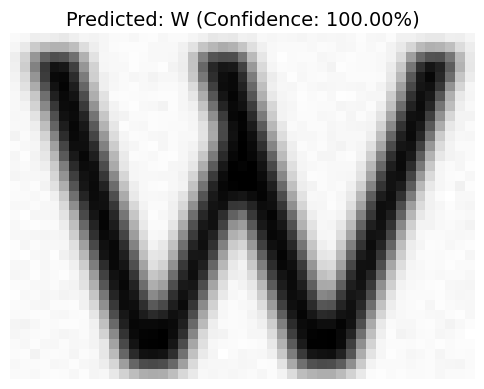

In [18]:
# Example prediction 
test_image_path = r"D:\Academic\My Courses\Year 3\Deep Learning\Project\data\testing_data\W\28738.png"  

if os.path.exists(test_image_path):
    predicted_class, confidence = predict_image(
        test_image_path,
        model,
        test_transform,
        device,
        train_dataset.classes
    )
    
    # Display result
    img = Image.open(test_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.2f}%)", fontsize=14)
    plt.axis('off')
    plt.show()
else:
    print(f"Test image not found: {test_image_path}")
    print("Please update the path to a valid test image")


**End of Notebook**